In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score
from collections import deque
from datetime import datetime

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 512

# Data

In [3]:
train = FashionMNIST('./data/fashion', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data/fashion', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [4]:
print('train x:', train.train_data.size())
print('train y:', train.train_labels.size())
print('test x:', test.test_data.size())
print('test y:', test.test_labels.size())

train x: torch.Size([60000, 28, 28])
train y: torch.Size([60000])
test x: torch.Size([10000, 28, 28])
test y: torch.Size([10000])


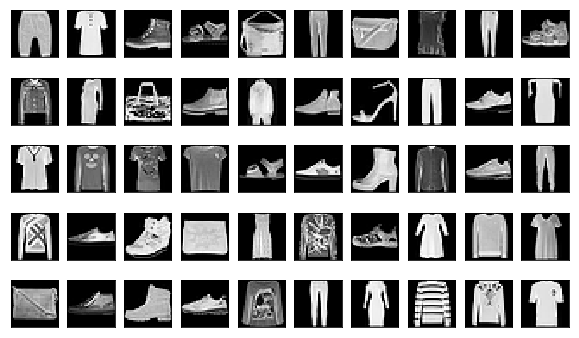

In [5]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channel:int=128):
        super(Discriminator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//3, kernel_size=4, stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(channel//3)
        
        self.conv2 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//2)
        
        self.conv3 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv4 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x):
        h = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        h = F.leaky_relu(self.bn2(self.conv2(h)), negative_slope=0.2)
        h = F.leaky_relu(self.bn3(self.conv3(h)), negative_slope=0.2)
        
        # Global Average Pooling
        h = F.leaky_relu(self.conv4(h), negative_slope=0.2)
        h = F.avg_pool2d(h, kernel_size=h.size()[2:]).view(h.size()[0], -1)
        output = F.sigmoid(h)
        return output
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

# noise = Variable(torch.randn((2, 100, 1, 1)).cuda())
# D(G(noise))

Discriminator(
  (conv1): Conv2d (1, 42, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (42, 64, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, noise:int=100, channel:int=128):
        super(Generator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        _c = channel
        
        self.noise = noise
        
        self.tp_conv1 = nn.ConvTranspose2d(noise, _c*6, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(_c*6)
        
        self.tp_conv2 = nn.ConvTranspose2d(_c*6, _c*5, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(_c*5)
        
        self.tp_conv3 = nn.ConvTranspose2d(_c*5, _c*3, kernel_size=5, stride=2, padding=2, bias=False)
        self.bn3 = nn.BatchNorm2d(_c*3)
                
        self.tp_conv4 = nn.ConvTranspose2d(_c*3, _c*2, kernel_size=6, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(_c*2)
        
        self.tp_conv5 = nn.ConvTranspose2d(_c*2, 1, kernel_size=7, stride=1, padding=1, bias=False)
    
    def forward(self, noise):
        h = self.tp_conv1(noise)
        h = F.relu(self.bn1(h))
#         print('h1', h.size())
        
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
#         print('h2', h.size())
        
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))
#         print('h3', h.size())

        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))
        
        h = self.tp_conv5(h)
        h = F.sigmoid(h)
#         print('h6', h.size())
        return h
    

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

noise = Variable(torch.randn((2, 100, 1, 1)).cuda())
G(noise).size()

Generator(
  (tp_conv1): ConvTranspose2d (100, 768, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv2): ConvTranspose2d (768, 640, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv3): ConvTranspose2d (640, 384, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv4): ConvTranspose2d (384, 256, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv5): ConvTranspose2d (256, 1, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
)


torch.Size([2, 1, 28, 28])

## Load Model

In [8]:
import os

def load_model(file='dcgan_mnist.pth.tar'):
    divergences, d_losses, g_losses, d_fake_losses, d_real_losses = None, None, None, None, None
    if os.path.exists(file):
        checkpoint = torch.load(file)
        G.load_state_dict(checkpoint['G'])
        D.load_state_dict(checkpoint['D'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer'])

        divergences = checkpoint['divergence']
        d_losses = checkpoint['d_losses']
        g_losses = checkpoint['g_losses']
        d_fake_losses = checkpoint['d_fake_losses']
        d_real_losses = checkpoint['d_real_losses']
    return divergences, d_losses, g_losses, d_fake_losses, d_real_losses
divergences, d_losses, g_losses, d_fake_losses, d_real_losses = load_model()

# Train

In [9]:
N_EPOCH = 350

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [10]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
_time = datetime.now()

for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        _batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((_batch_size, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_fake_pred = D(G(noise).detach())
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_pred = D(G(noise))
        g_loss = loss_f(y_pred, real_y[:_batch_size])
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 10 == 0:
            _time_delta = round((datetime.now() - _time).total_seconds(), 2)
            
            
            print(f'\rsec:{_time_delta:<6} [{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])),
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), end='')
    _time = datetime.now()
    print()

sec:106.01 [1/350] divergence: 0.551    D: 0.69     G:0.749    D_real: 0.508    D_fake: 0.69    
sec:108.27 [2/350] divergence: 0.625    D: 0.58     G:0.983    D_real: 0.353    D_fake: 0.58    
sec:111.64 [3/350] divergence: 0.684    D: 0.471    G:1.34     D_real: 0.31     D_fake: 0.471   
sec:108.72 [4/350] divergence: 0.729    D: 0.397    G:1.64     D_real: 0.273    D_fake: 0.397   
sec:109.5  [5/350] divergence: 0.799    D: 0.279    G:2.03     D_real: 0.196    D_fake: 0.279   
sec:106.65 [6/350] divergence: 0.857    D: 0.181    G:2.54     D_real: 0.17     D_fake: 0.181   
sec:106.52 [7/350] divergence: 0.904    D: 0.117    G:3.03     D_real: 0.117    D_fake: 0.117   
sec:106.32 [8/350] divergence: 0.903    D: 0.116    G:3.07     D_real: 0.137    D_fake: 0.116   
sec:106.43 [9/350] divergence: 0.933    D: 0.0798   G:3.52     D_real: 0.0949   D_fake: 0.0798  
sec:106.45 [10/350] divergence: 0.929    D: 0.0845   G:3.62     D_real: 0.103    D_fake: 0.0845  
sec:106.39 [11/350] divergenc

sec:105.28 [84/350] divergence: 0.919    D: 0.0962   G:3.43     D_real: 0.1      D_fake: 0.0962  
sec:105.19 [85/350] divergence: 0.928    D: 0.082    G:3.57     D_real: 0.098    D_fake: 0.082   
sec:105.23 [86/350] divergence: 0.933    D: 0.0734   G:3.65     D_real: 0.1      D_fake: 0.0734  
sec:105.23 [87/350] divergence: 0.928    D: 0.0802   G:3.68     D_real: 0.111    D_fake: 0.0802  
sec:105.26 [88/350] divergence: 0.931    D: 0.0764   G:3.72     D_real: 0.102    D_fake: 0.0764  
sec:105.28 [89/350] divergence: 0.926    D: 0.0841   G:3.7      D_real: 0.0983   D_fake: 0.0841  
sec:105.17 [90/350] divergence: 0.921    D: 0.0942   G:3.72     D_real: 0.104    D_fake: 0.0942  
sec:105.19 [91/350] divergence: 0.927    D: 0.0846   G:3.67     D_real: 0.108    D_fake: 0.0846  
sec:105.24 [92/350] divergence: 0.923    D: 0.0884   G:3.59     D_real: 0.125    D_fake: 0.0884  
sec:105.21 [93/350] divergence: 0.922    D: 0.0888   G:3.6      D_real: 0.134    D_fake: 0.0888  
sec:105.07 [94/350] 

sec:105.13 [166/350] divergence: 0.981    D: 0.0197   G:5.07     D_real: 0.0204   D_fake: 0.0197  
sec:106.02 [167/350] divergence: 0.984    D: 0.0171   G:5.07     D_real: 0.0199   D_fake: 0.0171  
sec:105.52 [168/350] divergence: 0.982    D: 0.0191   G:4.99     D_real: 0.0208   D_fake: 0.0191  
sec:104.77 [169/350] divergence: 0.978    D: 0.0232   G:4.78     D_real: 0.0229   D_fake: 0.0232  
sec:111.04 [170/350] divergence: 0.973    D: 0.0321   G:4.81     D_real: 0.0407   D_fake: 0.0321  
sec:108.46 [171/350] divergence: 0.972    D: 0.0328   G:4.88     D_real: 0.0414   D_fake: 0.0328  
sec:106.25 [172/350] divergence: 0.969    D: 0.0366   G:4.86     D_real: 0.047    D_fake: 0.0366  
sec:106.06 [173/350] divergence: 0.966    D: 0.0417   G:4.8      D_real: 0.0482   D_fake: 0.0417  
sec:106.38 [174/350] divergence: 0.96     D: 0.053    G:4.65     D_real: 0.0489   D_fake: 0.053   
sec:105.26 [175/350] divergence: 0.953    D: 0.0625   G:4.48     D_real: 0.0457   D_fake: 0.0625  
sec:105.64

sec:104.84 [248/350] divergence: 0.925    D: 0.0974   G:3.64     D_real: 0.102    D_fake: 0.0974  
sec:104.65 [249/350] divergence: 0.929    D: 0.094    G:3.81     D_real: 0.092    D_fake: 0.094   
sec:104.87 [250/350] divergence: 0.936    D: 0.0843   G:4.05     D_real: 0.0784   D_fake: 0.0843  
sec:107.19 [251/350] divergence: 0.945    D: 0.0634   G:4.07     D_real: 0.0635   D_fake: 0.0634  
sec:107.36 [252/350] divergence: 0.946    D: 0.0639   G:4.04     D_real: 0.0599   D_fake: 0.0639  
sec:105.91 [253/350] divergence: 0.953    D: 0.0547   G:4.13     D_real: 0.0522   D_fake: 0.0547  
sec:105.5  [254/350] divergence: 0.961    D: 0.0457   G:4.18     D_real: 0.0428   D_fake: 0.0457  
sec:105.5  [255/350] divergence: 0.965    D: 0.0393   G:4.25     D_real: 0.0475   D_fake: 0.0393  
sec:104.65 [256/350] divergence: 0.965    D: 0.0394   G:4.24     D_real: 0.0483   D_fake: 0.0394  
sec:106.71 [257/350] divergence: 0.965    D: 0.0416   G:4.38     D_real: 0.0556   D_fake: 0.0416  
sec:108.37

sec:104.78 [330/350] divergence: 0.964    D: 0.0414   G:4.26     D_real: 0.0442   D_fake: 0.0414  
sec:104.73 [331/350] divergence: 0.965    D: 0.0412   G:4.41     D_real: 0.0421   D_fake: 0.0412  
sec:104.79 [332/350] divergence: 0.967    D: 0.0385   G:4.5      D_real: 0.0454   D_fake: 0.0385  
sec:104.85 [333/350] divergence: 0.961    D: 0.0475   G:4.45     D_real: 0.0547   D_fake: 0.0475  
sec:104.87 [334/350] divergence: 0.959    D: 0.0495   G:4.39     D_real: 0.068    D_fake: 0.0495  
sec:104.78 [335/350] divergence: 0.961    D: 0.0457   G:4.41     D_real: 0.0665   D_fake: 0.0457  
sec:104.76 [336/350] divergence: 0.96     D: 0.0465   G:4.3      D_real: 0.0692   D_fake: 0.0465  
sec:104.8  [337/350] divergence: 0.961    D: 0.0442   G:4.19     D_real: 0.0637   D_fake: 0.0442  
sec:104.78 [338/350] divergence: 0.955    D: 0.0556   G:4.35     D_real: 0.0531   D_fake: 0.0556  
sec:104.82 [339/350] divergence: 0.947    D: 0.0684   G:4.34     D_real: 0.068    D_fake: 0.0684  
sec:104.75

## Save Model

In [11]:
def save_moodel():
    check_point = {'G': G.state_dict(), 
                   'D': D.state_dict(), 
                   'g_optimizer': g_optimizer.state_dict(),
                   'd_optimizer': d_optimizer.state_dict(),
                   'divergence': divergences, 
                   'd_losses': d_losses, 
                   'g_losses': g_losses, 
                   'd_fake_losses': d_fake_losses, 
                   'd_real_losses': d_real_losses}
    torch.save(check_point, 'dcgan-simple.pth.tar')
save_moodel()

## Loss Visualization

In [12]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

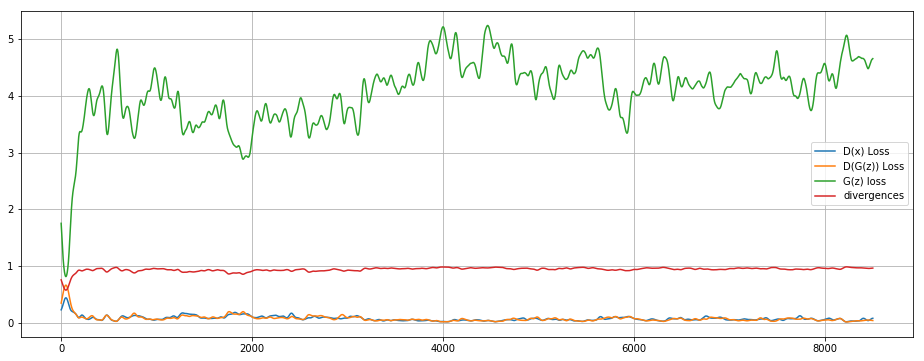

In [13]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

## Generator Evaluation

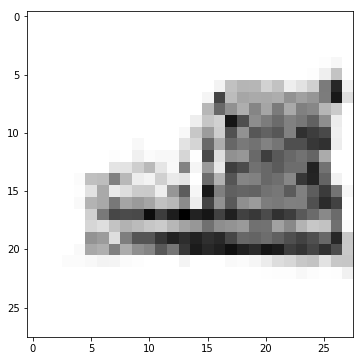

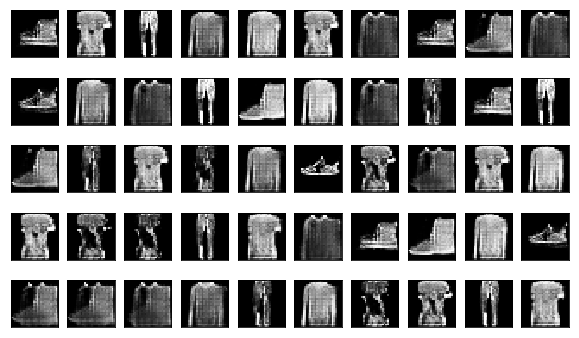

In [18]:
noise = Variable(torch.randn((128, 100, 1, 1)).cuda())
images = G(noise).view((-1, 28, 28)).data.cpu().numpy()
images = (images * 255).astype(np.uint8)
imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(5, 10) # subplots(y축, x축 갯수)
fig.set_figheight(6)
fig.set_figwidth(10)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray)
        idx += 1